**Step 0 - install and import dependencies**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 5.2 MB/s 
     |████████████████████████████████| 743 kB 57.0 MB/s 
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 86 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 52.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=3da27d7305015aaea2b65952682b89380e10bc8b03def46823af6c36f60bc21d
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=ca3118d76dbab7b829ac371ef849f462943bb2f6b1caae2691cbecc32ce5fe25
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [ ]:
df = pd.read_csv("../00 Datasets/Wongnai Reviews - Small.csv")

In [ ]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [ ]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [ ]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=80) #50
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

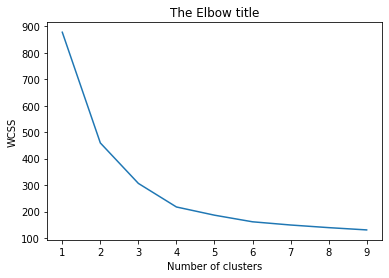

In [ ]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [ ]:
df_kmeans

,KMeans ID,texts
0,0,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
3,3,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...


In [ ]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [ ]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [ ]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [ ]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [ ]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'ร้า', 'ตั้งอยู่', 'ทาน', 
                 'ตั้งอยู่','อาหาร','กก','ผม','กิน','แวะ','น','เดิน','นขา','ราคา','สวัสดี',
                 'คิว','นึง','อ','เจอ','มีโอกาส','ลอง','ถนน','คน','วัง','กา','นิว','เติม',
                 'ศ','ซื้อ','ไหม','คุง','ขาย','รีวิว','นะคะ','าน','เลือก','บอ','หา','ตี','ไร้',
                 'ส','รา','ตี','น้ำ','จ','ชั้น']
screening_words = stopwords + removed_words

new_words = {"สตารบัก","ร้านกาแฟ","ร้านอาหาร","อเมซอน","ไม่ชอบ"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (อร่อย, 8), (ซอย, 6), (ส้มตำ..."
2,2,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ, เวียดนาม...","[(อร่อย, 7), (กาแฟ, 6), (บ้าน, 5), (ร้านกาแฟ, ..."
3,3,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[ชอบ, Macchiato, เป็นประจำ, เด, ArtofCoffeeKas...","[(ร้านกาแฟ, 22), (กาแฟ, 18), (ชอบ, 6), (น่ารัก..."


In [ ]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('ไต้หวัน', 3), ('ชาเขียว', 2), ('Ochaya', 2), ('Aprilstore', 2), ('สยาม', 2), ('ของหวาน', 2)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 11), ('อร่อย', 8), ('ซอย', 6), ('ส้มตำ', 5), ('เพื่อน', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ยำ', 3), ('เก่าแก่', 3)]

Cluster ID : 2

Most common words include : [('อร่อย', 7), ('กาแฟ', 6), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('ชอบ', 5), ('ร้านอาหาร', 5), ('พาย', 4), ('คาเฟ่', 3), ('ครั้งแรก', 3), ('ดี', 3)]

Cluster ID : 3

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 18), ('ชอบ', 6), ('น่ารัก', 5), ('นั่ง', 5), ('แนว', 4), ('กร้าน', 4), ('อเมซอน', 4), ('บรรยากาศ', 4), ('ดี', 4)]



In [ ]:
print(df_kmeans['texts'][2])

วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้านเป็นร้านที่สะดุดตาที่สุดบนถนนจรัญเลยก็ว่าได้สถานที่ตั้งร้านปากซอยสุขุมวิทบริเวณด้านซเคยทานทองม้วนสดมาหลายร้านแล้วnถ้าจะทานแบบอร่ขอไปกินกับเค้าบ้างเหอะแหมอยู่ใกล้บ้านตั้งขนาานพายจริณเป็นร้านคาเฟ่และเบเกอรี่เล็กๆที่มีสาคิดถึงร้านนี้มากสมัยเรียนพิเศษที่ดาวองก์เยาวรเดือนแรกที่เค้าต่อคิวกัน-ชั่วโมงเราก็ว่หันไปหันมาอยากไปแตะขอบฟ้าบ้างอะไรบ้างจะไปถึงร้านนี้ใครๆก็รู้จักว่าเป็นร้านกาแฟแต่อาหารขอร้านนี้เป็นของดาราตลกชื่อดังค่ะคุณหม่ำนั่นเองปังภูเขาไฟกับอ่กาศร้อนๆเข้ากันฝุดๆnหวานๆอร่ใครรักข้าวห่อไข่มาจานนี้จะจุใจมากเพราะเมนูเกมาครั้งแรกจะไปตัดสินใจอะไรได้น้อผมเดินจากลานจโดยส่วนตัวชอบIcecaramelmacchiatoที่สุดเพราสารภาพว่าไม่เคยคิดจะไปต่อคิวซื้อมากินเองครับบnn------------เกริ่นๆๆnnทริปลงใต้ครั้งนี้ร้านจะเป็นร้านนั่งแทบจะติดทะเลเลยนะคะอารมณ์ชามีโอกาสได้ไปกินไอติมที่ร้านนี้มาชอบตั้งแต่การมาคนเดียวเดินเลือกอยู่นานอยากกินอะไรที่ไม่อ้ชอบพายต้องร้านนี้มีพายหลากหลายแบบและรสชาติที่บอกว่าขอลบดาวออกดวงเพราะว่าคราวก่อน

**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [ ]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('ทาน', 416), ('รสชาติ', 407), ('ดี', 347), ('กิน', 339), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3)]

Cluster ID : 2

Most common words include : [('ดิชั้น', 4), ('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ("['", 1), ('ดิ', 1), ('ช้ัน', 1), ('ทบ', 1), ('น', 1)]

Cluster ID : 3

Most common words include : [('นม', 3), ('แน่น', 2), ('tamp', 2), ('เท', 2), ('แก้', 2), ("['", 1), ('เรื่อง', 1), ('ขนม', 1), ('สันทัด', 1), ('ดังนั้น', 1)]



**Step 4 - result discussion**

Usign K-means

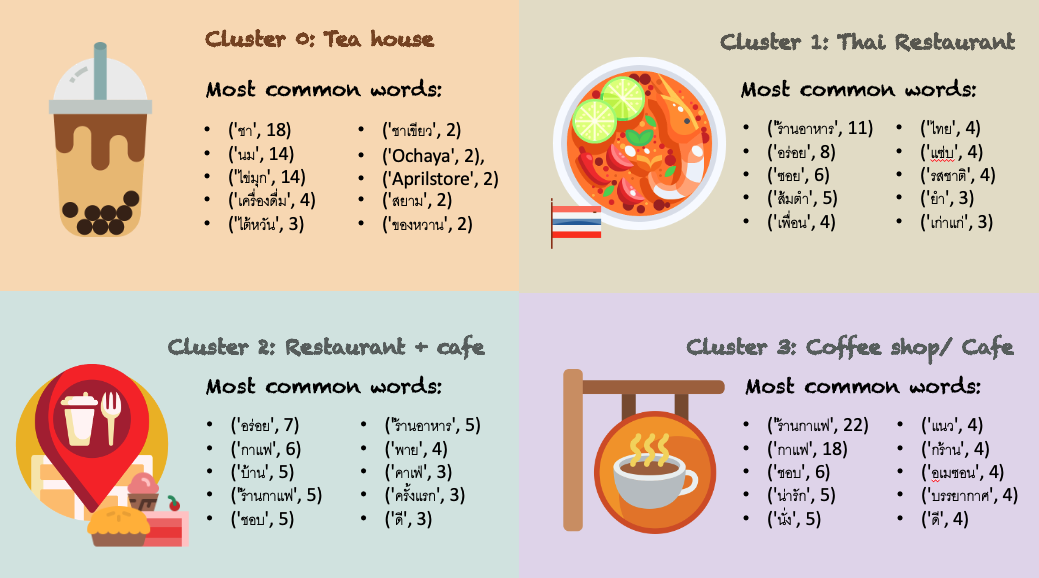